<a href="https://www.kaggle.com/code/fiestyautomaton/lstm-model?scriptVersionId=275047879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Define and instantiate the LSTMModel**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        
        # Define the first LSTM layer with 128 units
        self.lstm1 = nn.LSTM(input_size=2, hidden_size=128, batch_first=True)
        
        # Define the second LSTM layer with 64 units
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        
        # Define a fully connected layer with 1 output unit
        self.fc = nn.Linear(64, 1)
        
        # LeakyReLU activation
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        # Pass through the first LSTM layer
        x, _ = self.lstm1(x)
        x = self.leaky_relu(x)
        
        # Pass through the second LSTM layer
        x, _ = self.lstm2(x)
        x = self.leaky_relu(x)
        
        # Take the output of the last time step
        x = x[:, -1, :]
        
        # Pass through the dense layer with sigmoid activation
        x = self.fc(x)
        x = torch.sigmoid(x)
        
        return x

# Instantiate the model
model = LSTMModel()

# Print the model summary
print(model)


LSTMModel(
  (lstm1): LSTM(2, 128, batch_first=True)
  (lstm2): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
)


**Function to zero pad sequences to a fixed size**

In [2]:
def pad_to_fixed_size_pre(sequence, target_shape=(50, 2), padding_value=0):
    padded_sequence = np.full(target_shape, padding_value, dtype=sequence.dtype)
    rows_to_copy = min(sequence.shape[0], target_shape[0])
    padded_sequence[-rows_to_copy:, :] = sequence[:rows_to_copy, :]
    return padded_sequence

**Function to get a numpy array (n, time_steps, 0) from a human .csv file**

In [3]:
def getNumpy(path, time_steps = 50):
    real_dataframe = pd.read_csv(path)
    
    # real_seq_indices = real_seq[real_seq["state"] == "Pressed"].index
    
    dragging = 0
    startInd = 0
    groupIndices = []
    for i in range(real_dataframe.shape[0]):
        if dragging == 0 and real_dataframe.at[i, "state"] == "Pressed":
            groupIndices.append([startInd, i])
            startInd = i+1
            dragging = 1
        if dragging == 1 and real_dataframe.at[i, "state"] == "Released":
            if i - startInd > 5:
                groupIndices.append([startInd, i])
            startInd = i+1
            dragging = 0
    
    real_seq_numpy = np.zeros((0, time_steps, 2))

    # print(groupIndices)
    for indexPair in groupIndices:
        real_seq_numpy = np.append(real_seq_numpy, np.expand_dims(pad_to_fixed_size_pre(real_dataframe[["x", "y"]][indexPair[0]:indexPair[1]+1][::3].to_numpy(), target_shape = (time_steps, 2)), axis = 0), axis = 0)
        # if real_seq_numpy.shape[0] >= 32:
        #     break
    
    # print(real_seq_numpy.shape)
    return real_seq_numpy


**Read Bot Data**

In [4]:
import os
import pandas as pd
import numpy as np

# Convert data to PyTorch tensors if they are not already
folder_path = '/kaggle/input/function-based-generated-trajectories'


# Iterate over all files in the folder
botData = np.zeros((0, 50, 2))


for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    
    # Check if the current item is a file (not a directory)
    if os.path.isfile(file_path) and filename.endswith('.csv'):
        botData = np.concatenate((botData, np.expand_dims(pad_to_fixed_size_pre(pd.read_csv(file_path)[["x", "y"]].to_numpy()), axis = 0)), axis = 0)


print(botData.shape)

botLabels = np.zeros((botData.shape[0], 1))

maxHumanRecords = botData.shape[0]

(2000, 50, 2)


**Read human Data**

In [5]:
# Human csv files read here

humanData = np.zeros((0, 50, 2))

for dirpath, dirnames, filenames in os.walk("/kaggle/input/sapimouse/sapimouse"):
    broken = 0
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        humanData = np.concatenate((humanData, getNumpy(file_path)))
        if humanData.shape[0] > botData.shape[0]:
            broken = 1
            break
    if broken:
        break

humanLabels = np.ones((humanData.shape[0], 1))

**Mix Data**

In [6]:
data = np.concatenate((botData, humanData))
labels = np.concatenate((botLabels, humanLabels))

print(data.shape)

indices = np.random.permutation(len(data))
data = data[indices]
labels = labels[indices]

(4069, 50, 2)


**Split Data**

In [7]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.4)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

(2441, 50, 2) (1628, 50, 2) (2441, 1) (1628, 1)


**Code to make tensor dataloaders from these train and test numpy arrays.**

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

# Create DataLoader for batch processing
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Instantiation of the LSTM model, criterion and optimizer**

In [9]:
learning_rate = 0.0002

# Instantiate the model
model = LSTMModel()

# Define the loss function and optimizer
criterion = nn.BCELoss()          # Binary cross-entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


**Training Loop**

In [10]:
num_epochs = 20       # Number of training epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
    
    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 0.6827
Epoch [2/20], Loss: 0.3781
Epoch [3/20], Loss: 0.1667
Epoch [4/20], Loss: 0.1294
Epoch [5/20], Loss: 0.1123
Epoch [6/20], Loss: 0.1039
Epoch [7/20], Loss: 0.0963
Epoch [8/20], Loss: 0.0942
Epoch [9/20], Loss: 0.0895
Epoch [10/20], Loss: 0.0863
Epoch [11/20], Loss: 0.0894
Epoch [12/20], Loss: 0.0837
Epoch [13/20], Loss: 0.1003
Epoch [14/20], Loss: 0.0849
Epoch [15/20], Loss: 0.0834
Epoch [16/20], Loss: 0.0755
Epoch [17/20], Loss: 0.0758
Epoch [18/20], Loss: 0.0725
Epoch [19/20], Loss: 0.0696
Epoch [20/20], Loss: 0.0687


**Testing Loop**

In [11]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
TP = 0 #Corresponds to actual 0 ( bot ) and predicted 0 ( bot )
TN = 0 #Corresponds to actual 1 ( human ) and predicted 1 ( human )
FP = 0 #Corresponds to actual 0 ( bot ) and predicted 1 ( human )
FN = 0 #Corresponds to actual 1 ( human ) and predicted 0 ( bot )

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()  # Convert sigmoid output to binary predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        TP += np.count_nonzero((labels==0) & (predicted == 0))
        TN += np.count_nonzero((labels==1) & (predicted == 1))
        FP += np.count_nonzero((labels==0) & (predicted == 1))
        FN += np.count_nonzero((labels==1) & (predicted == 0))

# Calculate accuracy
accuracy = correct / total
precision = TP/(TP+FP) #Precision for bots
recall = TP/(TP+FN) #Recall for bots
f1score = 2*precision*recall/(precision + recall)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test f1score: {f1score * 100:.2f}%")

print("Confusion Matrix")
print(TP, FN, sep = '\t')
print(FP, TN, sep = '\t')

Test Accuracy: 98.65%
Test Precision: 99.87%
Test Recall: 97.42%
Test f1score: 98.63%
Confusion Matrix
794	21
1	812


**Check the misclassified human trajectories to verify.**

DONE


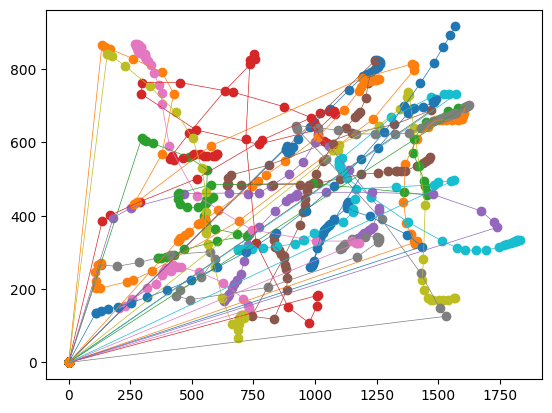

In [12]:
import matplotlib.pyplot as plt

for inputs, labels in test_loader:
    outputs = model(inputs)
    predicted = (outputs >= 0.5).float()
    for i in range(outputs.shape[0]):
        if labels[i, 0] != predicted[i, 0]:
            plt.scatter(inputs[i][:, 0], inputs[i][:, 1])
            plt.plot(inputs[i][:, 0], inputs[i][:, 1], linewidth = 0.5)
            # print(i, 'final')
        # print("Labels are \n", labels)
        # print("Outputs are \n", predicted)
print("DONE")

In [13]:
torch.save(model.state_dict(), "/kaggle/working/model_weights")
print("SAVED")

SAVED


In [14]:
# Evaluate the model on the test set
model.load_state_dict(torch.load("/kaggle/input/lstm-to-detect-bot-from-mouse-trajectory/pytorch/default/1/model_weights"))
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
TP = 0 #Corresponds to actual 0 ( bot ) and predicted 0 ( bot )
TN = 0 #Corresponds to actual 1 ( human ) and predicted 1 ( human )
FP = 0 #Corresponds to actual 0 ( bot ) and predicted 1 ( human )
FN = 0 #Corresponds to actual 1 ( human ) and predicted 0 ( bot )

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()  # Convert sigmoid output to binary predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        TP += np.count_nonzero((labels==0) & (predicted == 0))
        TN += np.count_nonzero((labels==1) & (predicted == 1))
        FP += np.count_nonzero((labels==0) & (predicted == 1))
        FN += np.count_nonzero((labels==1) & (predicted == 0))

# Calculate accuracy
accuracy = correct / total
precision = TP/(TP+FP) #Precision for bots
recall = TP/(TP+FN) #Recall for bots
f1score = 2*precision*recall/(precision + recall)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")
print(f"Test f1score: {f1score * 100:.2f}%")

print("Confusion Matrix")
print(TP, FN, sep = '\t')
print(FP, TN, sep = '\t')

/tmp/ipykernel_17/606691120.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/lstm-to-detect-bot-from-mouse-trajectory/pyto

Test Accuracy: 99.69%
Test Precision: 100.00%
Test Recall: 99.38%
Test f1score: 99.69%
Confusion Matrix
795	5
0	828


**.py file integrated into web server**

In [15]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import pandas as pd
# import numpy as np

# def pad_to_fixed_size_pre(sequence, target_shape=(50, 2), padding_value=0):
#     padded_sequence = np.full(target_shape, padding_value, dtype=sequence.dtype)
#     rows_to_copy = min(sequence.shape[0], target_shape[0])
#     padded_sequence[-rows_to_copy:, :] = sequence[:rows_to_copy, :]
#     return padded_sequence

# def getNumpy(path, time_steps = 50):
#     real_dataframe = pd.read_csv(path)
    
#     # real_seq_indices = real_seq[real_seq["state"] == "Pressed"].index
    
#     dragging = 0
#     startInd = 0
#     groupIndices = []
#     for i in range(real_dataframe.shape[0]):
#         if dragging == 0 and real_dataframe.at[i, "state"] == "Pressed":
#             groupIndices.append([startInd, i])
#             startInd = i+1
#             dragging = 1
#         if dragging == 1 and real_dataframe.at[i, "state"] == "Released":
#             if i - startInd > 5:
#                 groupIndices.append([startInd, i])
#             startInd = i+1
#             dragging = 0
    
#     real_seq_numpy = np.zeros((0, time_steps, 2))

#     # print(groupIndices)
#     for indexPair in groupIndices:
#         real_seq_numpy = np.append(real_seq_numpy, np.expand_dims(pad_to_fixed_size_pre(real_dataframe[["x", "y"]][indexPair[0]:indexPair[1]+1][::3].to_numpy(), target_shape = (time_steps, 2)), axis = 0), axis = 0)
#         # if real_seq_numpy.shape[0] >= 32:
#         #     break
    
#     # print(real_seq_numpy.shape)
#     return real_seq_numpy


# class LSTMModel(nn.Module):
#     def __init__(self):
#         super(LSTMModel, self).__init__()
        
#         # Define the first LSTM layer with 128 units
#         self.lstm1 = nn.LSTM(input_size=2, hidden_size=128, batch_first=True)
        
#         # Define the second LSTM layer with 64 units
#         self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        
#         # Define a fully connected layer with 1 output unit
#         self.fc = nn.Linear(64, 1)
        
#         # LeakyReLU activation
#         self.leaky_relu = nn.LeakyReLU(0.01)
        
#     def forward(self, x):
#         # Pass through the first LSTM layer
#         x, _ = self.lstm1(x)
#         x = self.leaky_relu(x)
        
#         # Pass through the second LSTM layer
#         x, _ = self.lstm2(x)
#         x = self.leaky_relu(x)
        
#         # Take the output of the last time step
#         x = x[:, -1, :]
        
#         # Pass through the dense layer with sigmoid activation
#         x = self.fc(x)
#         x = torch.sigmoid(x)
        
#         return x

# # Instantiate the model
# model = LSTMModel()

# model.load_state_dict(torch.load("/kaggle/working/model_weights"))
# #Put model weight path here
# npArr = getNumpy("/kaggle/input/extracteddata/mouse_data.csv")
# #Put input file path here
# tensorArr = torch.tensor(npArr, dtype=torch.float32)
# tensorLabels = torch.tensor(np.zeros((npArr.shape[0], 1)), dtype = torch.float32)
# tensorDataset = TensorDataset(tensorArr, tensorLabels)
# myLoader = DataLoader(tensorDataset, batch_size=32, shuffle=True)
# print(tensorDataset)

# # Evaluate the model on the test set
# model.eval()  # Set the model to evaluation mode
# correct = 0
# total = 0

# labelArray = []
# with torch.no_grad():  # Disable gradient computation
#     for inputs, labels in myLoader:
#         outputs = model(inputs)
#         predicted = (outputs >= 0.5)  # Convert sigmoid output to binary predictions
#         for i in range(predicted.shape[0]):
#             labelArray.append(int(predicted[i, 0]))
# print(labelArray)
# labelDF = pd.DataFrame(labelArray, columns = ["label"])
# labelDF.to_csv("/kaggle/working/finalCsvPath.csv", index = False)